In [5]:
import os
import sys
from typing import List

# Adding root project path to sys.path
project_root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root_path)

from sequence.kernel.process import Process
from sequence.kernel.event import Event
from sequence.topology.qlan_star_topo import QlanStarTopo
from sequence.kernel.timeline import Timeline
import sequence.utils.log as log

import numpy as np
import matplotlib.pyplot as plt

# Qlan imports
from sequence.qlan.qlan_orchestrator import QlanOrchestratorNode
from sequence.qlan.qlan_client import QlanClientNode
from sequence.qlan.qlan_measurement import QlanMeasurementProtocol

In [6]:
'''
This benchmark file is WIP. 
It is intended to be a more user-friendly way to run experiments with QLAN.
'''

class PeriodicApp:
    def __init__(self, tl: "Timeline", orchestrator: "QlanOrchestratorNode", clients: List["QlanClientNode"]):
        self.orch = orchestrator
        self.orch.set_app(self)
        self.clients = clients
        self.tl = tl

        self.local_memories = []
        for i in range(len(self.orch.resource_manager.memory_names)):
            memo = self.orch.components[self.orch.resource_manager.memory_names[i]]
            self.local_memories.append(memo)

        self.remote_memories = []
        for node_obj in clients:
            memo = node_obj.get_components_by_type("Memory")[0]
            self.remote_memories.append(memo)

        self.pair_protocol()
        self.display_state_information()

    def start(self):
        now = self.orch.timeline.now()
                
        # schedule future start
        process = Process(self, "start", [])
        event = Event(now + PERIOD, process)

        # actual operations to be performed
        self.orch.timeline.schedule(event)        
        self.perform_measurements()

    
    def perform_measurements(self):

        # Preparation
        self.orch.reset_linear_state(self.tl)

        print("--------------------------------------------------------------")
        print(f"\n  Orchestrator Measurement started at {format(self.tl.now())}\n")
        print("--------------------------------------------------------------")

        for client in self.clients:
            client.protocols[0].start()

        self.orch.protocols[0].start(self.orch)


    def pair_protocol(self):
        
        # Assuming that protocol 0 is the measurement protocol!
        p_orch = self.orch.protocols[0]
        
        protocols_names = []
        clients_names = []
        clients_memory_names = []
        
        for client in self.clients:
            p_client = client.protocols[0]
            protocols_names.append(p_client)
            clients_names.append(client.name)
            clients_memory_names.append(client.resource_manager.memory_names[0])

            p_client.set_others(p_orch.name, self.orch.name, self.local_memories)

        p_orch.set_others(protocols_names, clients_names, self.local_memories)

    # Function to convert a state vector to a density matrix
    def state_vector_to_density_matrix(self, state_vector: "KetState"):
        state = state_vector.state
        state_vector = np.array(state, dtype=np.complex128)
        density_matrix = np.outer(state_vector, np.conj(state_vector))
        return density_matrix

    def plot_density_matrix(self, density_matrix):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
            
        # Real part
        im1 = ax1.imshow(density_matrix.real, cmap='viridis')
        ax1.set_title('Real Part of Density Matrix')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_xticks(np.arange(density_matrix.shape[1]))
        ax1.set_yticks(np.arange(density_matrix.shape[0]))
        ax1.set_xticklabels(np.arange(density_matrix.shape[1]), rotation=90)
        ax1.set_yticklabels(np.arange(density_matrix.shape[0]))
        ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax1.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        fig.colorbar(im1, ax=ax1, shrink=0.75)
            
        # Imaginary part
        im2 = ax2.imshow(density_matrix.imag, cmap='viridis')
        ax2.set_title('Imaginary Part of Density Matrix')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_xticks(np.arange(density_matrix.shape[1]))
        ax2.set_yticks(np.arange(density_matrix.shape[0]))
        ax2.set_xticklabels(np.arange(density_matrix.shape[1]), rotation=90)
        ax2.set_yticklabels(np.arange(density_matrix.shape[0]))
        ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        fig.colorbar(im2, ax=ax2, shrink=0.75)
            
        plt.tight_layout()
        plt.rcParams["font.family"] = "serif"
        plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
        plt.show()

    def display_state_information(self, plot_density=True):
        print("Local Memories:")
        print("----------------------------------------")
        for i, memory in enumerate(self.local_memories):
            print(f"Memory {memory.name}:")
            print(f"  Entangled Memory: {memory.entangled_memory}")
            print(f"  Quantum state stored in memories{memory.qstate_key+1}:")
            print(f"  {self.tl.quantum_manager.states[i+len(self.local_memories)+1]}")
            if plot_density:
                dm = self.state_vector_to_density_matrix(self.tl.quantum_manager.states[i+len(self.local_memories)+1])
                self.plot_density_matrix(dm)
            print("----------------------------------------")
        
        print("Remote Memories:")
        print("----------------------------------------")
        for i, memory in enumerate(self.remote_memories):
            print(f"Memory {memory.name}:")
            print(f"  Entangled Memory: {memory.entangled_memory}")
            print(f"  Quantum state stored in memories{memory.qstate_key+1}:")
            print(f"  {self.tl.quantum_manager.states[i]}")
            if plot_density:
                dm = self.state_vector_to_density_matrix(self.tl.quantum_manager.states[i])
                self.plot_density_matrix(dm)
            print("----------------------------------------")

In [7]:
# Choose the number of clients configuration
NUM_CLIENTS= 5
network_config = f"topologies/qlan_topology_{NUM_CLIENTS}.json"

In [8]:
NUM_PERIODS = 1
PERIOD = 1e12
client_nodes = []

network_topo = QlanStarTopo(network_config)
tl = network_topo.get_timeline()
tl.stop_time = PERIOD * NUM_PERIODS
tl.show_progress = True

Target keys:  [5, 6, 7, 8]
Target array:  [0, 5, 1, 6, 2, 7, 3, 8, 4]
{5: [0, 1], 6: [1, 2], 7: [2, 3], 8: [3, 4]}


In [9]:
# set log
log_filename = "qlan_app.log"
log.set_logger(__name__, tl, log_filename)
log.set_logger_level('DEBUG')
#log.set_logger_level('INFO')

log.track_module('qlan_orchestrator')
log.track_module('qlan_correction')
log.track_module('qlan_measurement')
log.track_module('qlan_client')
#log.track_module('timeline')

Local Memories:
----------------------------------------
Memory Orchestrator.memo_o_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory6:
  Keys:
[0, 5, 1, 6, 2, 7, 3, 8, 4]
State:
[ 0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j -0.04419417+0.j


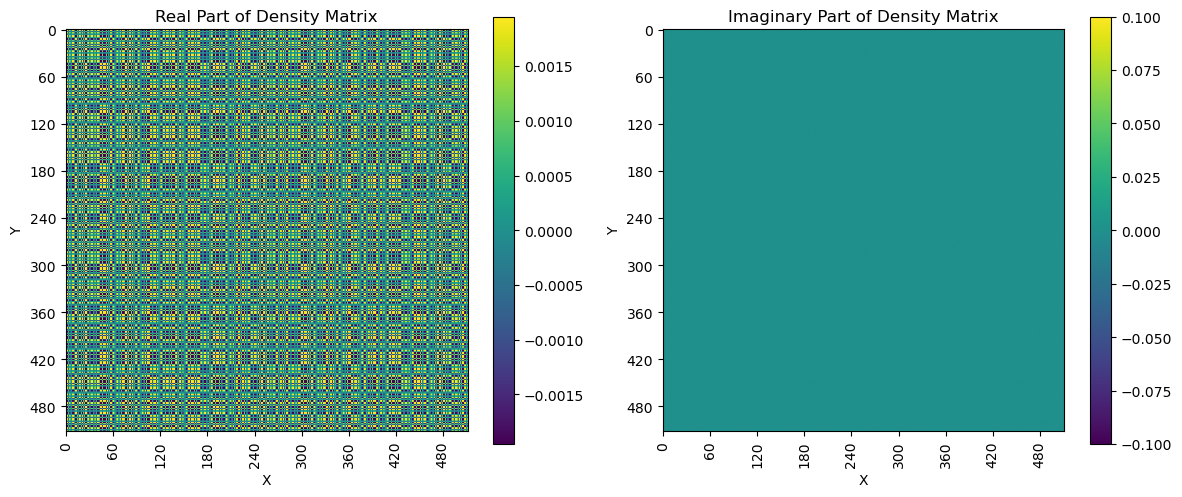

----------------------------------------
Memory Orchestrator.memo_o_2:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory7:
  Keys:
[0, 5, 1, 6, 2, 7, 3, 8, 4]
State:
[ 0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j

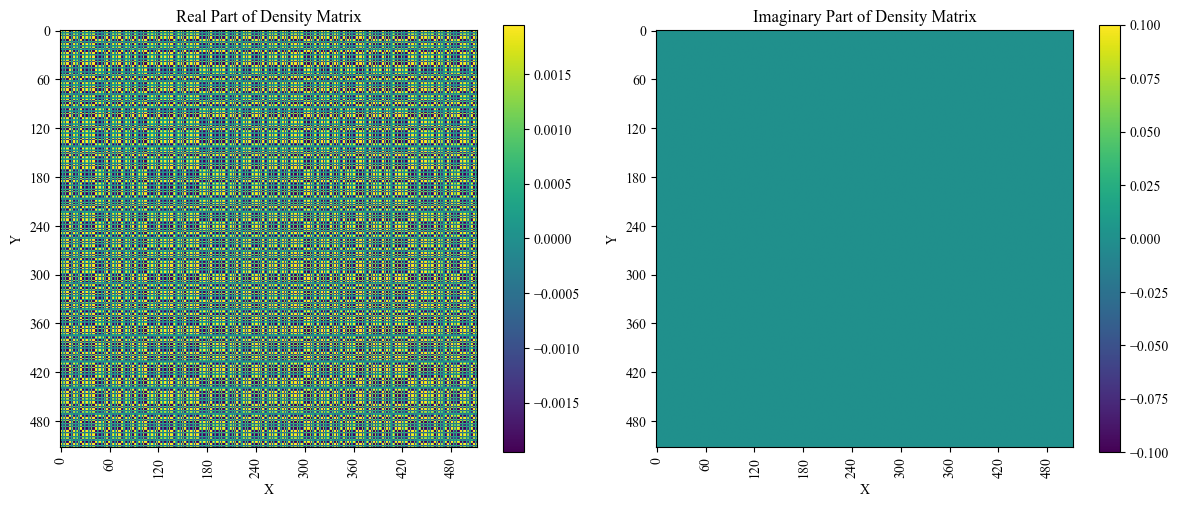

----------------------------------------
Memory Orchestrator.memo_o_3:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory8:
  Keys:
[0, 5, 1, 6, 2, 7, 3, 8, 4]
State:
[ 0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j

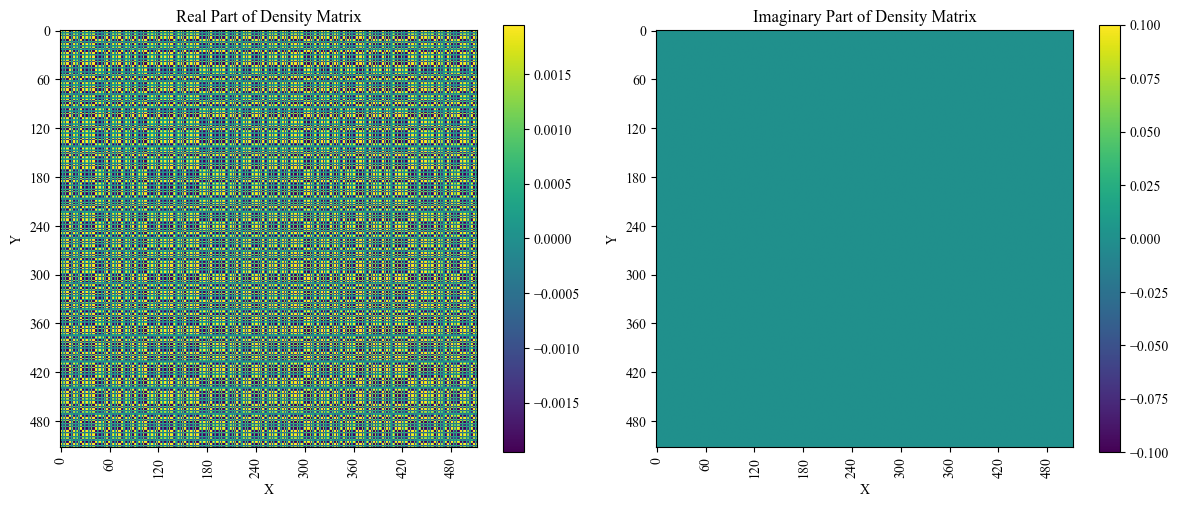

----------------------------------------
Memory Orchestrator.memo_o_4:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory9:
  Keys:
[0, 5, 1, 6, 2, 7, 3, 8, 4]
State:
[ 0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j

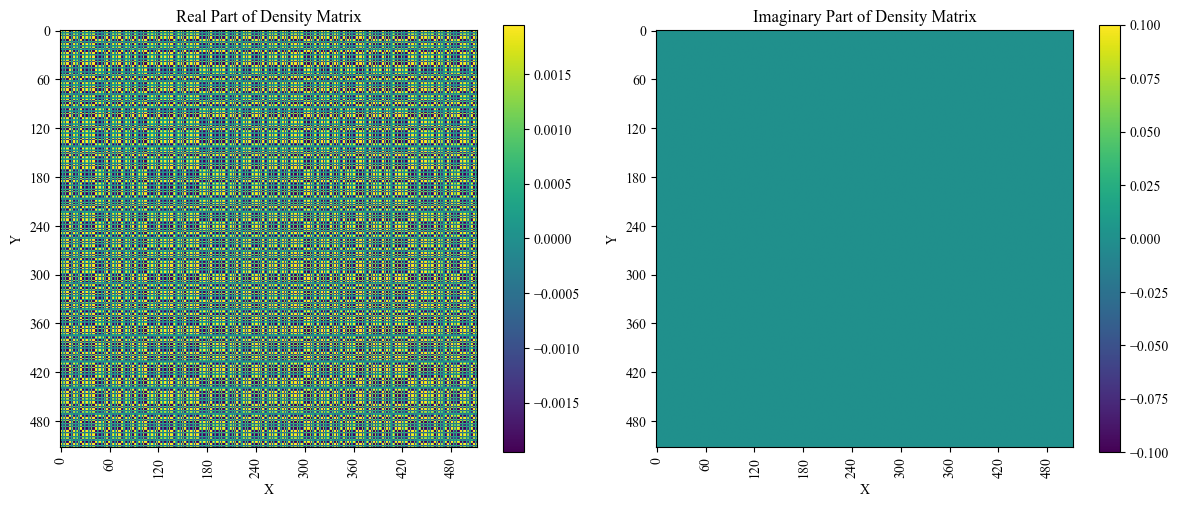

----------------------------------------
Remote Memories:
----------------------------------------
Memory client1.memo_c_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory1:
  Keys:
[0, 5, 1, 6, 2, 7, 3, 8, 4]
State:
[ 0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417

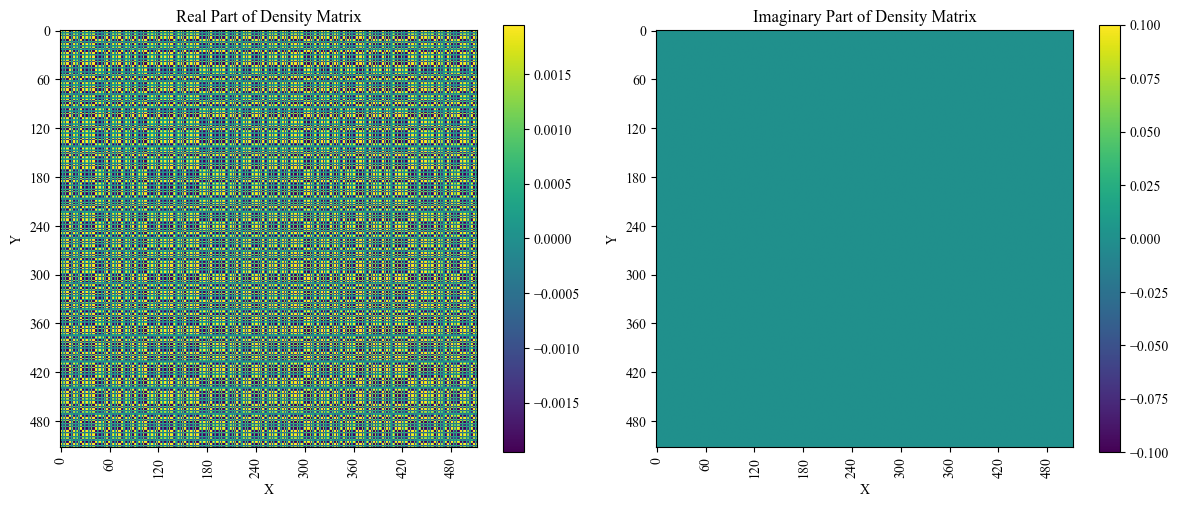

----------------------------------------
Memory client2.memo_c_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory2:
  Keys:
[0, 5, 1, 6, 2, 7, 3, 8, 4]
State:
[ 0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.0

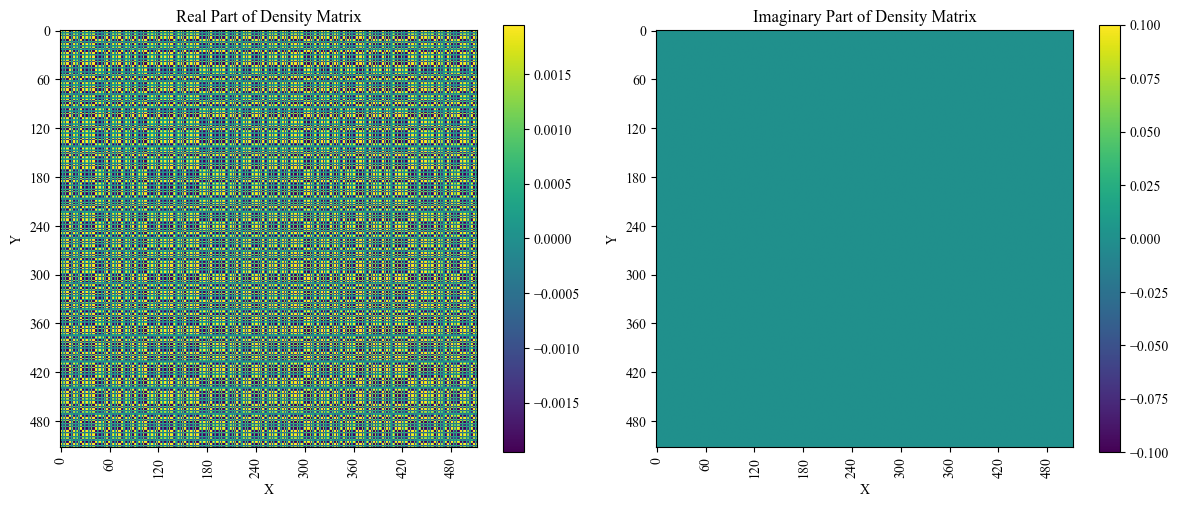

----------------------------------------
Memory client3.memo_c_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory3:
  Keys:
[0, 5, 1, 6, 2, 7, 3, 8, 4]
State:
[ 0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.0

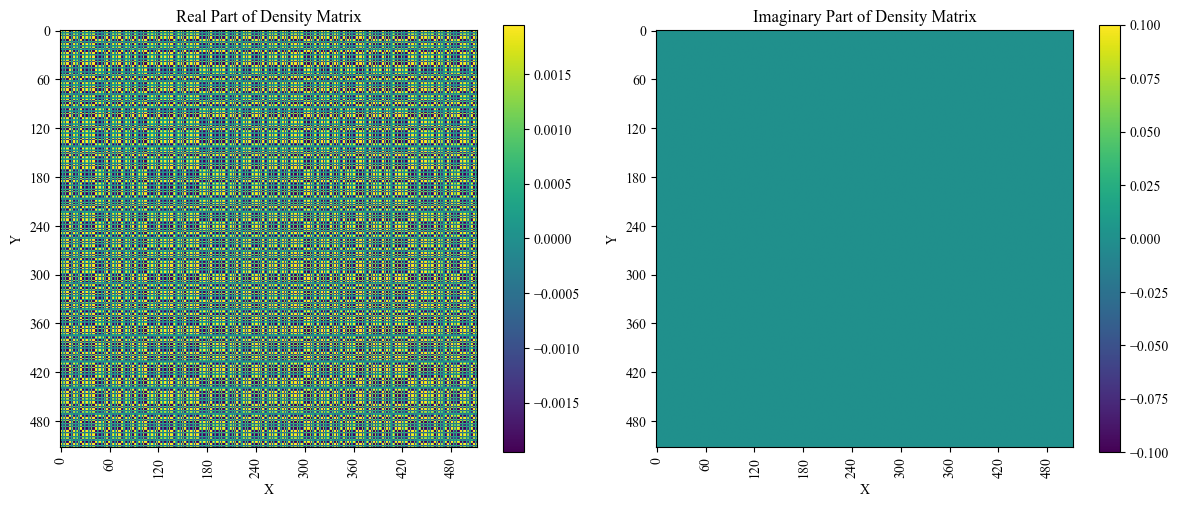

----------------------------------------
Memory client4.memo_c_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory4:
  Keys:
[0, 5, 1, 6, 2, 7, 3, 8, 4]
State:
[ 0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.0

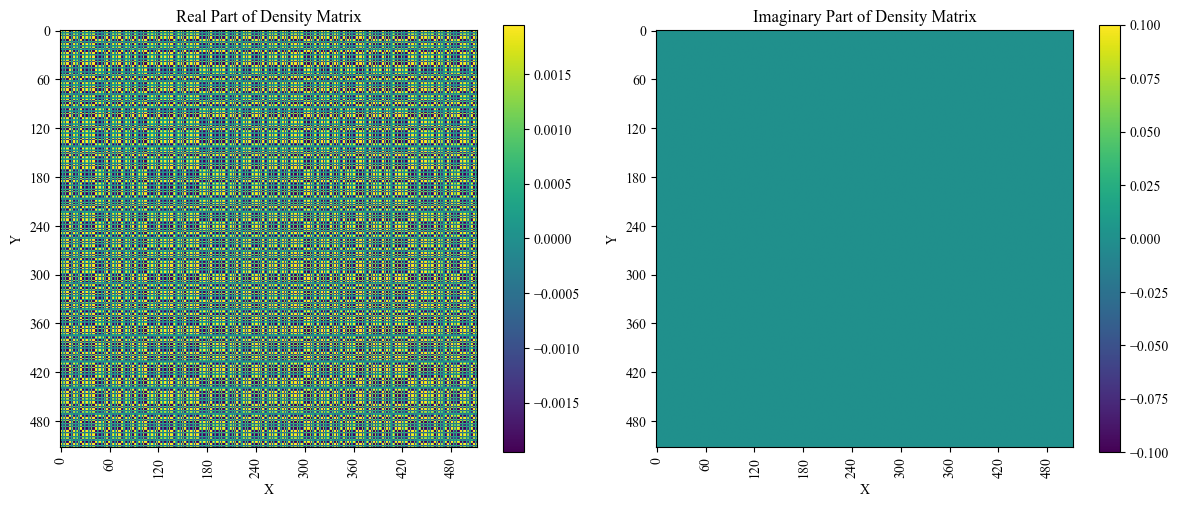

----------------------------------------
Memory client5.memo_c_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory5:
  Keys:
[0, 5, 1, 6, 2, 7, 3, 8, 4]
State:
[ 0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j  0.04419417+0.j
  0.04419417+0.j  0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.04419417+0.j  0.04419417+0.j -0.04419417+0.j
 -0.04419417+0.j -0.0

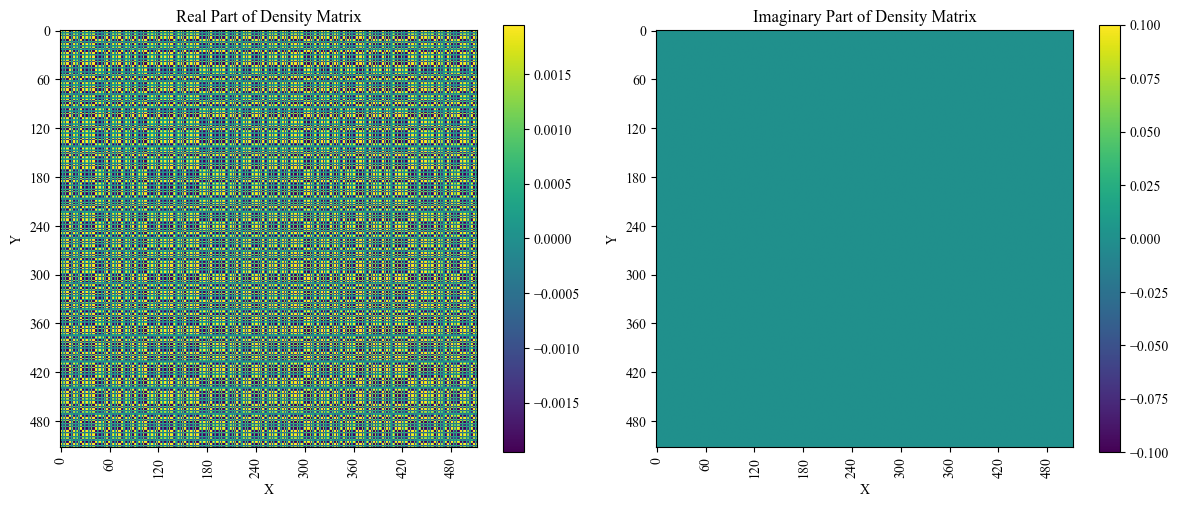

INFO:__main__:
PROTOCOL STARTED: Correction Protocol starts at node client1
INFO:__main__:
PROTOCOL STARTED: Correction Protocol starts at node client2
INFO:__main__:
PROTOCOL STARTED: Correction Protocol starts at node client3
INFO:__main__:
PROTOCOL STARTED: Correction Protocol starts at node client4
INFO:__main__:
PROTOCOL STARTED: Correction Protocol starts at node client5
INFO:__main__:
PROTOCOL STARTED: Measurement Protocol starts at node Orchestrator
DEBUG:__main__:
ORCHESTRATOR DEBUG: init message_list defaultdict(<class 'list'>, {})
DEBUG:__main__:
ORCHESTRATOR DEBUG: adjacent_nodes {5: [0, 1], 6: [1, 2], 7: [2, 3], 8: [3, 4]}
DEBUG:__main__:
ORCHESTRATOR DEBUG: local_memory_identifiers [5, 6, 7, 8]
DEBUG:__main__:
ORCHESTRATOR DEBUG: CURRENT IDENTIFIER 5
DEBUG:__main__:
ORCHESTRATOR DEBUG: Na is now updated [0, 1]
DEBUG:__main__:
ORCHESTRATOR DEBUG: message_list defaultdict(<class 'list'>, {0: [<QlanMeasurementMsgType.Y_Outcome1: 4>], 1: [<QlanMeasurementMsgType.Y_Outcome1: 4

----------------------------------------
Target keys:  [5, 6, 7, 8]
Target array:  [0, 5, 1, 6, 2, 7, 3, 8, 4]
{5: [0, 1], 6: [1, 2], 7: [2, 3], 8: [3, 4]}
--------------------------------------------------------------

  Orchestrator Measurement started at 0

--------------------------------------------------------------


INFO:__main__:
MESSAGE RECEIVED: client1 received message from Orchestrator of type QlanMeasurementMsgType.Y_Outcome1  at 500000000
INFO:__main__:
APPLYING CORRECTION: Applying minus root iZ at client1
INFO:__main__:
PROTOCOL ENDED: client1 executed Correction Protocol at 500000000
INFO:__main__:
MESSAGE RECEIVED: client2 received message from Orchestrator of type QlanMeasurementMsgType.Y_Outcome1  at 500000000
INFO:__main__:
APPLYING CORRECTION: Applying minus root iZ at client2
INFO:__main__:
PROTOCOL ENDED: client2 executed Correction Protocol at 500000000
INFO:__main__:
MESSAGE RECEIVED: client2 received message from Orchestrator of type QlanMeasurementMsgType.Y_Outcome0  at 500000000
INFO:__main__:
APPLYING CORRECTION: Applying root iZ at client2
INFO:__main__:
PROTOCOL ENDED: client2 executed Correction Protocol at 500000000
INFO:__main__:
MESSAGE RECEIVED: client3 received message from Orchestrator of type QlanMeasurementMsgType.Y_Outcome0  at 500000000
INFO:__main__:
APPLYING C

In [10]:
for node in network_topo.get_nodes_by_type(QlanStarTopo.ORCHESTRATOR):
    orchestrator = node
for node in network_topo.get_nodes_by_type(QlanStarTopo.CLIENT):
    client_nodes.append(node)

app = PeriodicApp(tl=tl, orchestrator=orchestrator, clients=client_nodes)
#reset_app = ResetApp(node2, start_node_name)

tl.init()
app.start()
tl.run()



############# SIMULATION ENDED #############


Local Memories:
----------------------------------------
Memory Orchestrator.memo_o_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory6:
  Keys:
[5]
State:
[0.+0.j 1.+0.j]


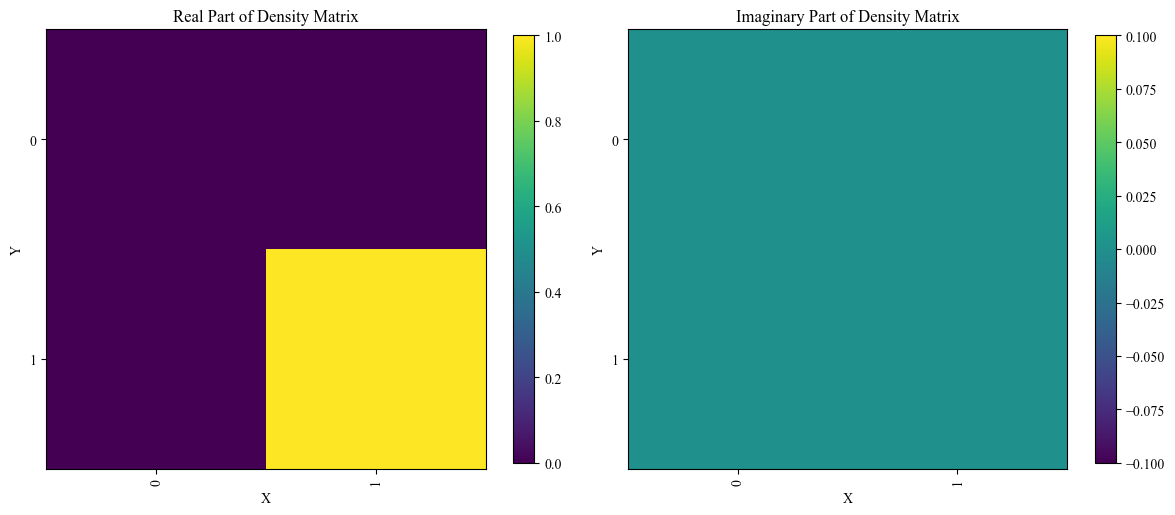

----------------------------------------
Memory Orchestrator.memo_o_2:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory7:
  Keys:
[6]
State:
[1.+0.j 0.+0.j]


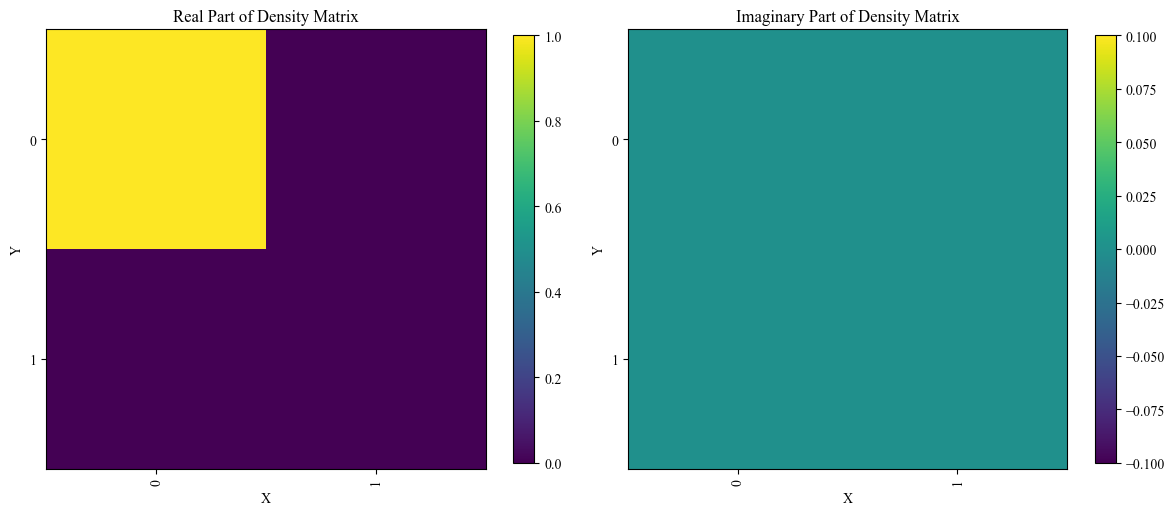

----------------------------------------
Memory Orchestrator.memo_o_3:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory8:
  Keys:
[7]
State:
[0.+0.j 1.+0.j]


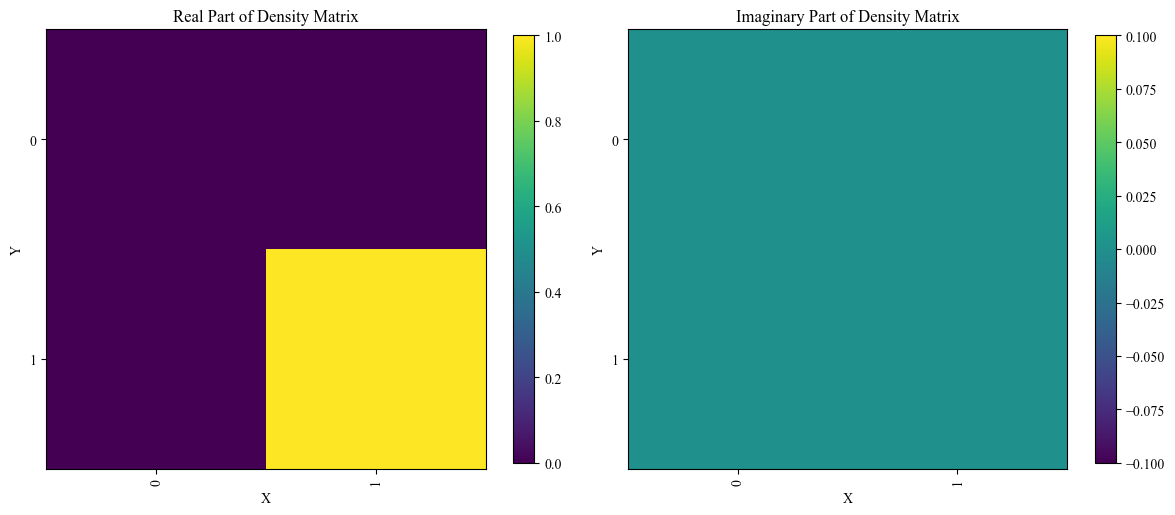

----------------------------------------
Memory Orchestrator.memo_o_4:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory9:
  Keys:
[8]
State:
[0.+0.j 1.+0.j]


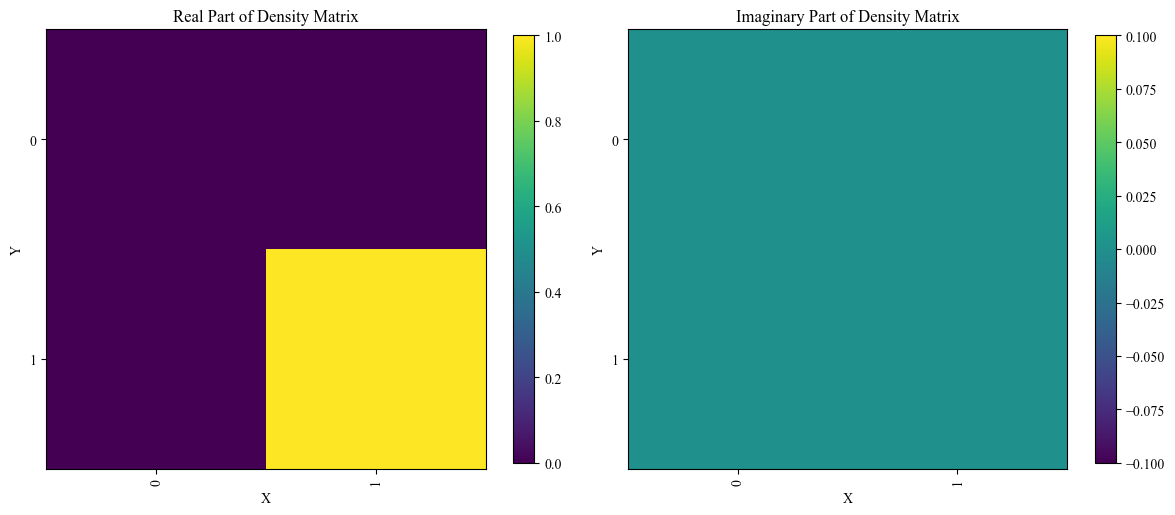

----------------------------------------
Remote Memories:
----------------------------------------
Memory client1.memo_c_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory1:
  Keys:
[4, 0, 2, 1, 3]
State:
[-2.38105196e-18-0.1767767j -1.62588398e-17-0.1767767j
 -2.38105196e-18-0.1767767j -1.62588398e-17-0.1767767j
  2.13098137e-17-0.1767767j -3.11228916e-17+0.1767767j
  2.38105196e-18+0.1767767j -1.62588398e-17-0.1767767j
 -2.38105196e-18-0.1767767j -1.62588398e-17-0.1767767j
  2.38105196e-18+0.1767767j  1.62588398e-17+0.1767767j
 -2.38105196e-18-0.1767767j  1.62588398e-17+0.1767767j
 -2.38105196e-18-0.1767767j  1.62588398e-17+0.1767767j
  1.62588398e-17-0.1767767j -2.38105196e-18+0.1767767j
  1.62588398e-17-0.1767767j -2.38105196e-18+0.1767767j
  1.62588398e-17-0.1767767j  2.38105196e-18-0.1767767j
  3.11228916e-17+0.1767767j  2.13098137e-17+0.1767767j
  1.62588398e-17-0.1767767j -2.38105196e-18+0.1767767j
 -1.62588398e-17+0.1767767j  2.38105196e

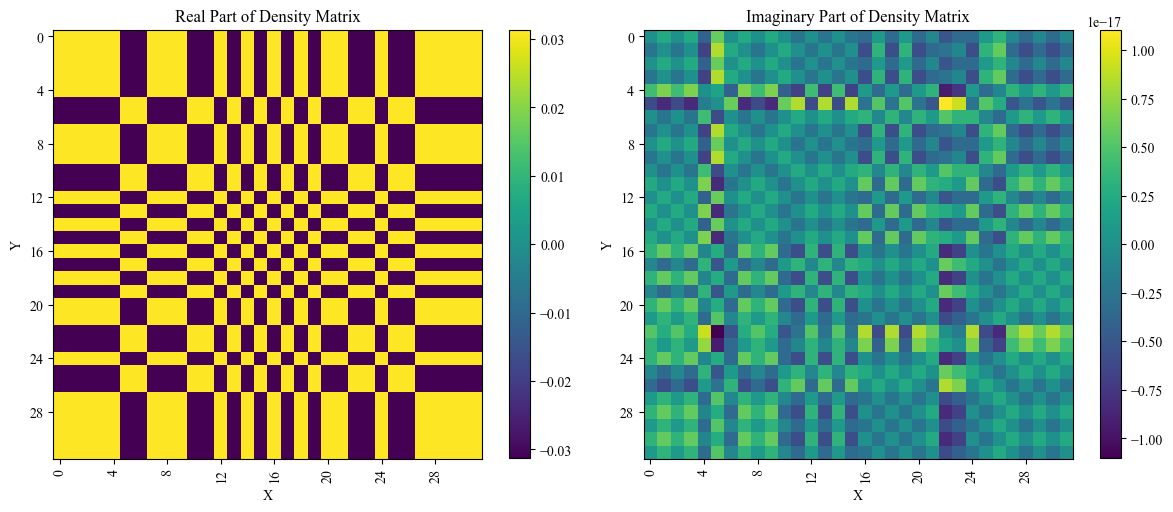

----------------------------------------
Memory client2.memo_c_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory2:
  Keys:
[4, 0, 2, 1, 3]
State:
[-2.38105196e-18-0.1767767j -1.62588398e-17-0.1767767j
 -2.38105196e-18-0.1767767j -1.62588398e-17-0.1767767j
  2.13098137e-17-0.1767767j -3.11228916e-17+0.1767767j
  2.38105196e-18+0.1767767j -1.62588398e-17-0.1767767j
 -2.38105196e-18-0.1767767j -1.62588398e-17-0.1767767j
  2.38105196e-18+0.1767767j  1.62588398e-17+0.1767767j
 -2.38105196e-18-0.1767767j  1.62588398e-17+0.1767767j
 -2.38105196e-18-0.1767767j  1.62588398e-17+0.1767767j
  1.62588398e-17-0.1767767j -2.38105196e-18+0.1767767j
  1.62588398e-17-0.1767767j -2.38105196e-18+0.1767767j
  1.62588398e-17-0.1767767j  2.38105196e-18-0.1767767j
  3.11228916e-17+0.1767767j  2.13098137e-17+0.1767767j
  1.62588398e-17-0.1767767j -2.38105196e-18+0.1767767j
 -1.62588398e-17+0.1767767j  2.38105196e-18-0.1767767j
  1.62588398e-17-0.1767767j  2.38105196e-18

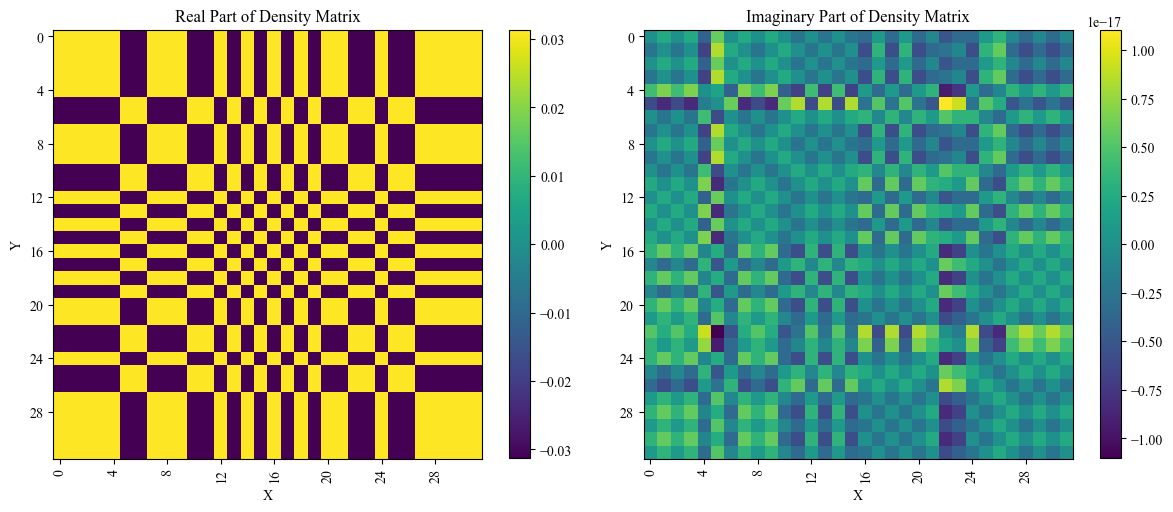

----------------------------------------
Memory client3.memo_c_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory3:
  Keys:
[4, 0, 2, 1, 3]
State:
[-2.38105196e-18-0.1767767j -1.62588398e-17-0.1767767j
 -2.38105196e-18-0.1767767j -1.62588398e-17-0.1767767j
  2.13098137e-17-0.1767767j -3.11228916e-17+0.1767767j
  2.38105196e-18+0.1767767j -1.62588398e-17-0.1767767j
 -2.38105196e-18-0.1767767j -1.62588398e-17-0.1767767j
  2.38105196e-18+0.1767767j  1.62588398e-17+0.1767767j
 -2.38105196e-18-0.1767767j  1.62588398e-17+0.1767767j
 -2.38105196e-18-0.1767767j  1.62588398e-17+0.1767767j
  1.62588398e-17-0.1767767j -2.38105196e-18+0.1767767j
  1.62588398e-17-0.1767767j -2.38105196e-18+0.1767767j
  1.62588398e-17-0.1767767j  2.38105196e-18-0.1767767j
  3.11228916e-17+0.1767767j  2.13098137e-17+0.1767767j
  1.62588398e-17-0.1767767j -2.38105196e-18+0.1767767j
 -1.62588398e-17+0.1767767j  2.38105196e-18-0.1767767j
  1.62588398e-17-0.1767767j  2.38105196e-18

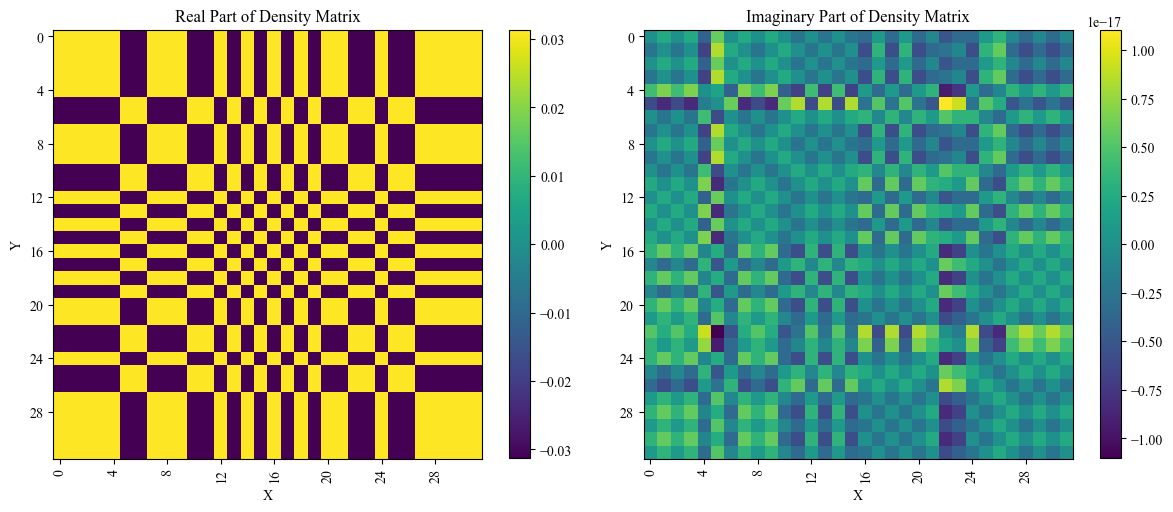

----------------------------------------
Memory client4.memo_c_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory4:
  Keys:
[4, 0, 2, 1, 3]
State:
[-2.38105196e-18-0.1767767j -1.62588398e-17-0.1767767j
 -2.38105196e-18-0.1767767j -1.62588398e-17-0.1767767j
  2.13098137e-17-0.1767767j -3.11228916e-17+0.1767767j
  2.38105196e-18+0.1767767j -1.62588398e-17-0.1767767j
 -2.38105196e-18-0.1767767j -1.62588398e-17-0.1767767j
  2.38105196e-18+0.1767767j  1.62588398e-17+0.1767767j
 -2.38105196e-18-0.1767767j  1.62588398e-17+0.1767767j
 -2.38105196e-18-0.1767767j  1.62588398e-17+0.1767767j
  1.62588398e-17-0.1767767j -2.38105196e-18+0.1767767j
  1.62588398e-17-0.1767767j -2.38105196e-18+0.1767767j
  1.62588398e-17-0.1767767j  2.38105196e-18-0.1767767j
  3.11228916e-17+0.1767767j  2.13098137e-17+0.1767767j
  1.62588398e-17-0.1767767j -2.38105196e-18+0.1767767j
 -1.62588398e-17+0.1767767j  2.38105196e-18-0.1767767j
  1.62588398e-17-0.1767767j  2.38105196e-18

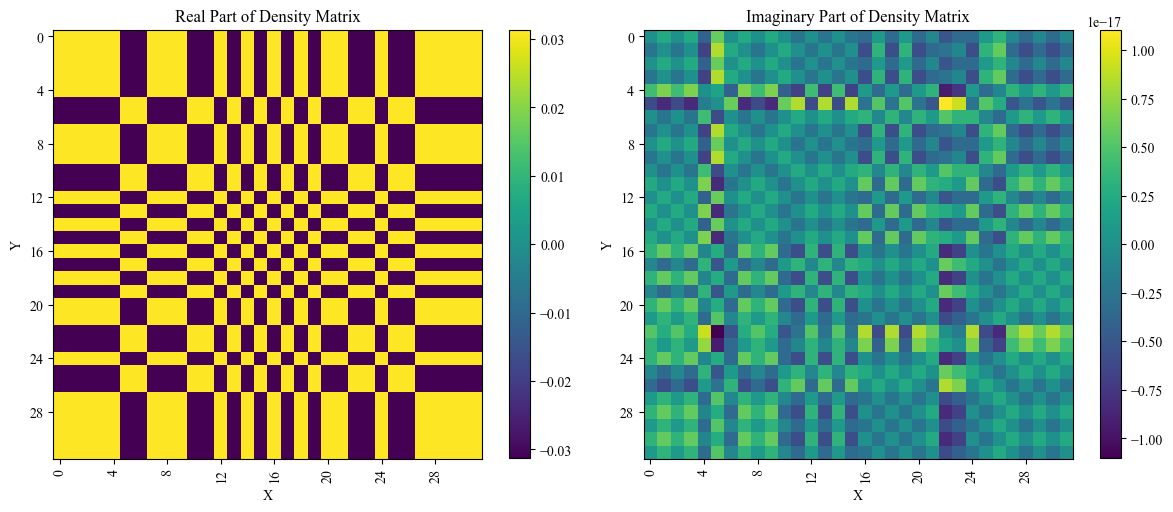

----------------------------------------
Memory client5.memo_c_1:
  Entangled Memory: {'node_id': None, 'memo_id': None}
  Quantum state stored in memory5:
  Keys:
[4, 0, 2, 1, 3]
State:
[-2.38105196e-18-0.1767767j -1.62588398e-17-0.1767767j
 -2.38105196e-18-0.1767767j -1.62588398e-17-0.1767767j
  2.13098137e-17-0.1767767j -3.11228916e-17+0.1767767j
  2.38105196e-18+0.1767767j -1.62588398e-17-0.1767767j
 -2.38105196e-18-0.1767767j -1.62588398e-17-0.1767767j
  2.38105196e-18+0.1767767j  1.62588398e-17+0.1767767j
 -2.38105196e-18-0.1767767j  1.62588398e-17+0.1767767j
 -2.38105196e-18-0.1767767j  1.62588398e-17+0.1767767j
  1.62588398e-17-0.1767767j -2.38105196e-18+0.1767767j
  1.62588398e-17-0.1767767j -2.38105196e-18+0.1767767j
  1.62588398e-17-0.1767767j  2.38105196e-18-0.1767767j
  3.11228916e-17+0.1767767j  2.13098137e-17+0.1767767j
  1.62588398e-17-0.1767767j -2.38105196e-18+0.1767767j
 -1.62588398e-17+0.1767767j  2.38105196e-18-0.1767767j
  1.62588398e-17-0.1767767j  2.38105196e-18

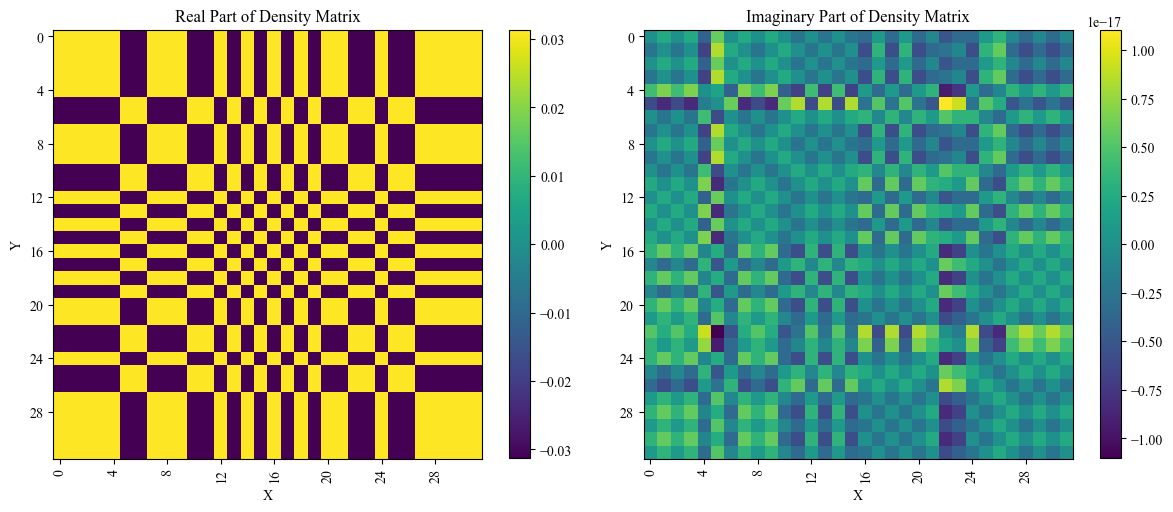

----------------------------------------


In [11]:
# End of simulation quantum state...
print("\n\n############# SIMULATION ENDED #############\n\n")
app.display_state_information()